# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [378]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [379]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [380]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [381]:
#your turn
import numpy as np
df = pd.merge(df_offers, df_transactions)
# create a "pivot table" which will give us the number of times each customer responded to a given offer
pv = df.pivot_table(index=['customer_name'], columns=['offer_id'], values='n')
# a little tidying up. fill NA values with 0 and make the index into a column
pv = pv.fillna(0).reset_index()
# save a list of the 0/1 columns. we'll use these a bit later
x_cols = pv.columns[1:]
pv.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

+ The SS (also called inertia) value that suddenly drops with increase in k by 1 represents better clustering. The reason lies in why we want clusters in the first place. SS is definitely the least if each point is assigned to its own cluster, but that is not why we wanted clusters. We want meaningful groups and the SS is an indication of how meaningfully they are separated from each other.

In [382]:
# your turn
X = np.array(pv[x_cols])
X

array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  1.]])

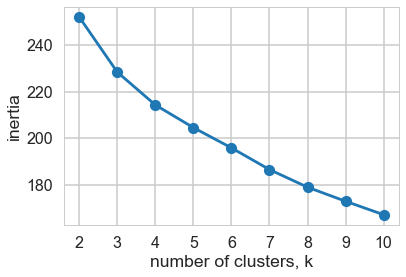

In [383]:
from sklearn.cluster import KMeans
ks = range(2, 11)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(X)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

+ There is huge drop in inertia for K =3, then slightly at K=5, and then on it is approximately linear. It appears slightly dropping at k=10 again. 10 is too much. 3 might lose some information. For a start, let us pick median of these, that is 5 and check.

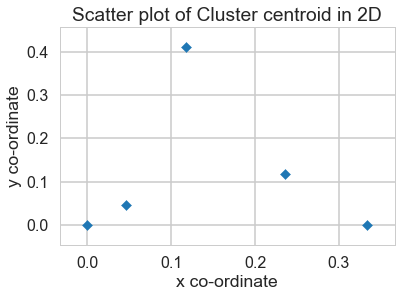

AxesSubplot(0.125,0.125;0.775x0.755)


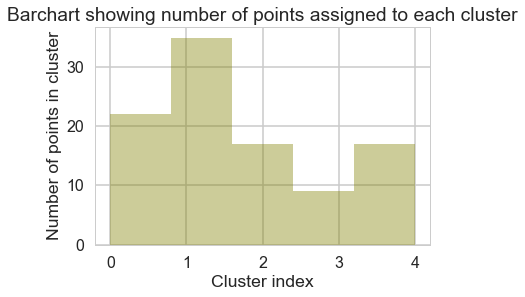

In [410]:
model = KMeans(n_clusters=5,random_state=42)
model.fit(X)
# Assign the cluster centers: centroids
centroids = model.cluster_centers_
labels = model.labels_
# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

# Make a scatter plot of centroids_x and centroids_y
plt.scatter(centroids_x,centroids_y,marker='D',s=50)
plt.title('Scatter plot of Cluster centroid in 2D')
plt.xlabel('x co-ordinate')
plt.ylabel('y co-ordinate')
plt.show()
sns.distplot(labels, kde=False, rug=False,bins=5,color='olive');
plt.xlabel('Cluster index')
plt.ylabel('Number of points in cluster')
plt.title('Barchart showing number of points assigned to each cluster')
print(cc)

+ Challenge to pick best k: It was obvious that one good choice is K=3, however we checked the inertia till k=10 and there is a gap of at least inertia value 60 between k=3 and k=10. But it was not very convincing to select k=10. The scatterplot of the centroid confirms that there are some clusters too closely spaced. 
+ From the centroid plot above, it K=5 seems optimal choice. But let us remember that this would change, had we chosen random_state differently in KMeans() initialization.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

In [385]:
# Your turn.
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


print(__doc__)
def silhoute_plot(X,model,n_clusters=3):
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, model.labels_)
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(9, 7)

    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.3, 0.5])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    y_lower =0
    sil_avg = 0
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()
        sil_avg = sil_avg + ith_cluster_silhouette_values.sum()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for K={}".format(n_clusters))
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    sil_avg = sil_avg / float(len(model.labels_))

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=sil_avg, color="red", linestyle="--")
    return sil_avg

Automatically created module for IPython interactive environment


For n_clusters = 2 The average silhouette_score is : 0.0917487150875
For n_clusters = 3 The average silhouette_score is : 0.115424070379
For n_clusters = 4 The average silhouette_score is : 0.0967025836069
For n_clusters = 5 The average silhouette_score is : 0.145315688203
For n_clusters = 6 The average silhouette_score is : 0.133131266271
For n_clusters = 7 The average silhouette_score is : 0.130739507718
For n_clusters = 8 The average silhouette_score is : 0.123975729011
For n_clusters = 9 The average silhouette_score is : 0.120246511094
For n_clusters = 10 The average silhouette_score is : 0.126951431234
The best Silhouette score is 0.14531568820332333 for K= 5


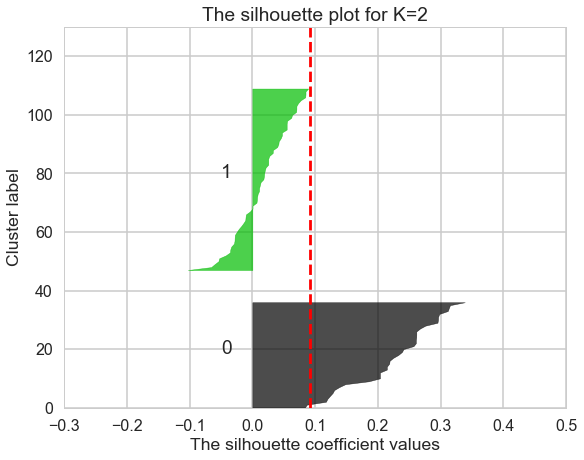

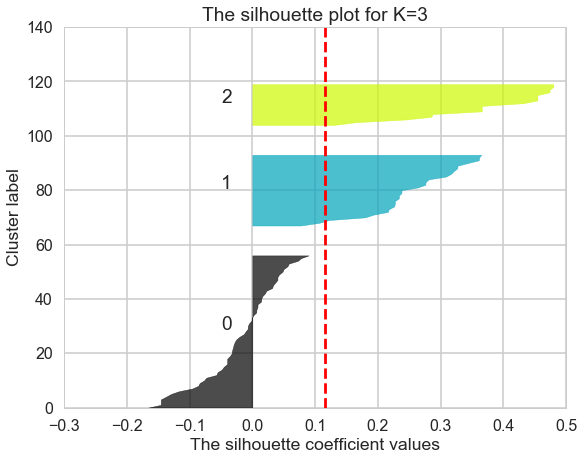

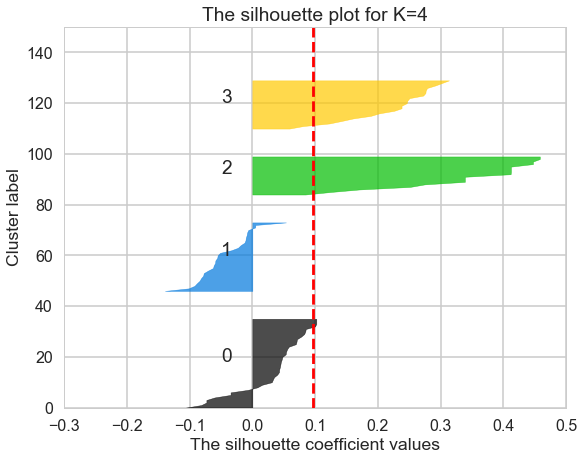

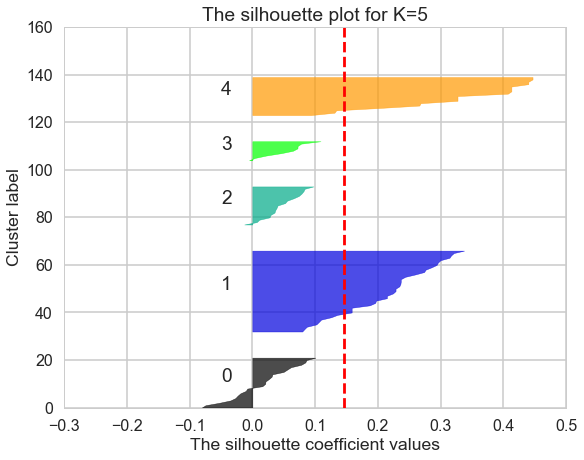

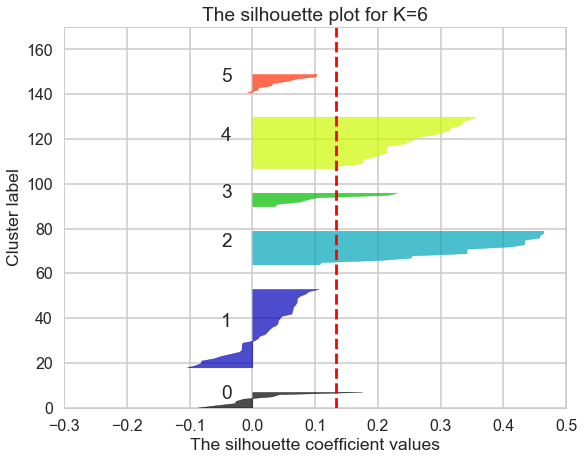

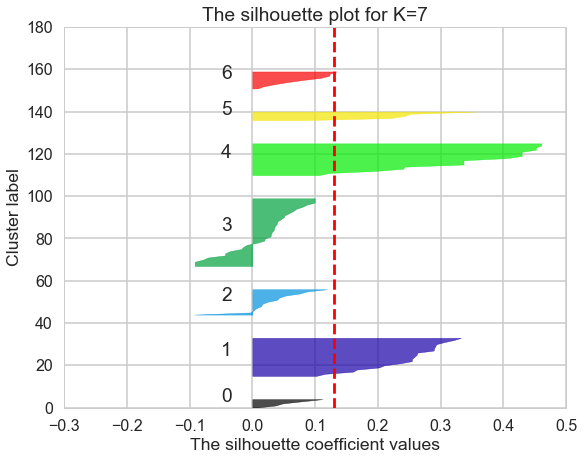

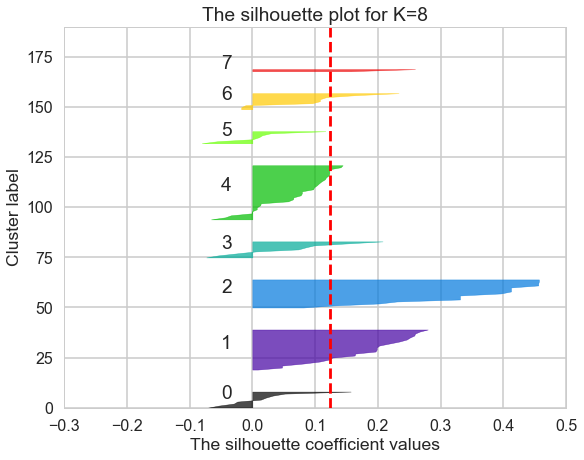

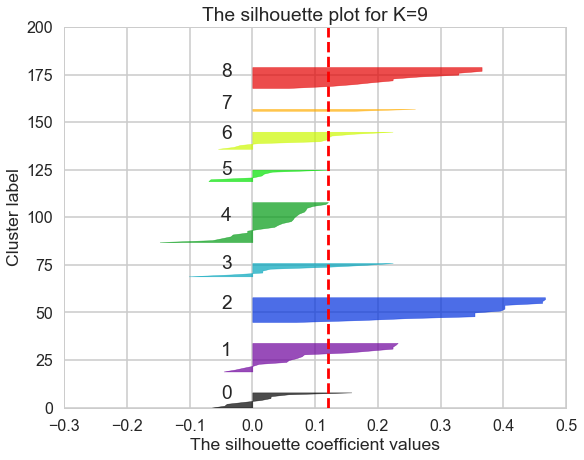

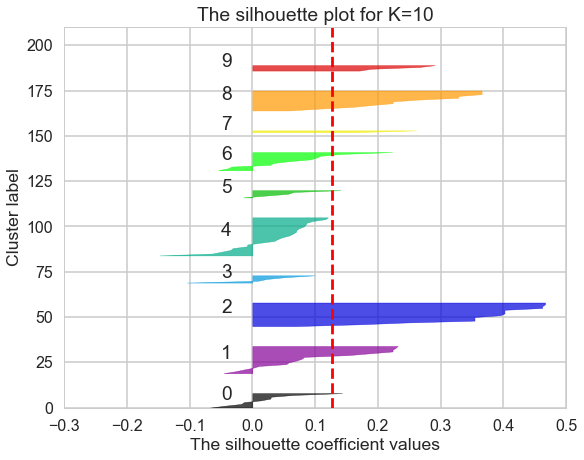

In [386]:
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10]
sl_avg_sc = list()
for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X)
    
    sil_avg = silhoute_plot(X,clusterer,n_clusters=n_clusters)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", sil_avg)
    sl_avg_sc.append(sil_avg)

print("The best Silhouette score is {} for K= {}".format(np.array(sl_avg_sc).max(),np.array(sl_avg_sc).argmax()+2))

From the above result, based on Silhoutte score, all K values produce clusters with weak boundaries. Out of them K=5 is the best with a score of 0.141

Using Elbow method on inertia (SS value) it was a bit confusing to choose and we chose 10 anyway. Using Silhoutte method, K = 10 gives a score of 0.119, which is much below 0.141 corresponding to 5.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

Text(0.5,1,'Scatter plot of clusters with K=2')

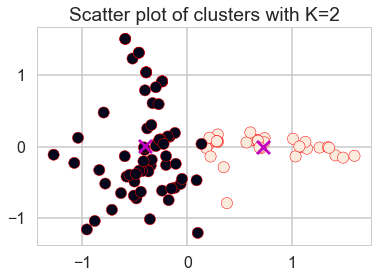

In [441]:
#your turn
from sklearn.decomposition import PCA
model = PCA(n_components=2)
xx = model.fit_transform(X)
xs = xx[:,0]
ys = xx[:,1]
kmeans=KMeans(n_clusters=2,random_state=42) # Random state is to ensure labels are same each time
kmeans.fit(xx)
centroids = kmeans.cluster_centers_
cl_id = kmeans.labels_.reshape(-1,1)
temp_a = np.concatenate((cl_id,xx),axis=1)
#Creating dataframe
dfp = pd.DataFrame(temp_a,columns=['cluster_id','x','y'])
dfp['customer_name'] = pv['customer_name']
#Plotting scatterplot
plt.scatter(dfp.x,dfp.y,c=dfp.cluster_id,edgecolor='r')
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='m', zorder=10)
plt.title('Scatter plot of clusters with K=2')

+ From the plot above, clusters do not look too well separated.
+ Visually it is harder to make out what is the best value of K. Also, it is not possible by looking at 2D scatterplot to say which method would give optimal K value. But, not restricting the number of components in PCA, instead doing PCA analysis and looking at variance, it is possible to say what is the optimum value of K


What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

In [564]:
# Here we analyse the raw data to answer the second part of Exercise Set V
n_com = 5
model = PCA(n_components=n_com)
xx = model.fit_transform(X)
xs = xx[:,0]
ys = xx[:,1]
kmeans=KMeans(n_clusters=n_com,random_state=42) # Random state is to ensure labels are same each time
kmeans.fit(xx)
centroids = kmeans.cluster_centers_
cl_id = kmeans.labels_.reshape(-1,1)

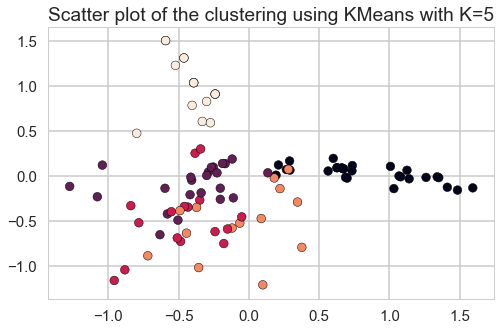

In [565]:
plt.figure(figsize=(8,5))
plt.scatter(xx[:,0],xx[:,1],edgecolors='k',c=cl_id.reshape(xx[:,0].shape),s=75)
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Scatter plot of the clustering using KMeans with K=5')
plt.show()

In [566]:
temp_a = np.concatenate((cl_id,xx),axis=1)
dfp = pd.DataFrame(temp_a,columns=['cluster_id','x','y','pca2','pca3','pca4'])
dfp['customer_name'] = pv['customer_name']
dft = pd.merge(dfp,df)
dft.head()

,cluster_id,x,y,pca2,pca3,pca4,customer_name,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,n
0,0.0,1.007580,0.108215,0.545614,-0.066764,-0.246179,Adams,18,July,Espumante,6,50,Oregon,False,1
1,0.0,1.007580,0.108215,0.545614,-0.066764,-0.246179,Adams,29,November,Pinot Grigio,6,87,France,False,1
2,0.0,1.007580,0.108215,0.545614,-0.066764,-0.246179,Adams,30,December,Malbec,6,54,France,False,1
3,1.0,-0.287539,0.044715,-0.044072,-0.572682,0.044524,Allen,9,April,Chardonnay,144,57,Chile,False,1
4,1.0,-0.287539,0.044715,-0.044072,-0.572682,0.044524,Allen,27,October,Champagne,72,88,New Zealand,False,1


In [567]:
print('Count of unique entries in each column')
dft.nunique()

Count of unique entries in each column


cluster_id         5
x                 93
y                 92
pca2              93
pca3              92
pca4              94
customer_name    100
offer_id          32
campaign          12
varietal           9
min_qty            4
discount          27
origin             9
past_peak          2
n                  1
dtype: int64

In [568]:
dfg = dft.groupby('cluster_id')
for name, group in dfg :
    print("Cluster id {} top 2 varietal preferences".format(name))
    ss = group.varietal.value_counts().head(2)
    print(ss.index[0],ss.iloc[0])
    print(ss.index[1],ss.iloc[1])

Cluster id 0.0 top 2 varietal preferences
Espumante 23
Malbec 17
Cluster id 1.0 top 2 varietal preferences
Champagne 25
Cabernet Sauvignon 22
Cluster id 2.0 top 2 varietal preferences
Champagne 27
Malbec 11
Cluster id 3.0 top 2 varietal preferences
Champagne 26
Espumante 16
Cluster id 4.0 top 2 varietal preferences
Pinot Noir 37
Prosecco 2


In [526]:
for name, group in dfg :
    print("Cluster id {} top 2 origin preferences".format(name))
    ss = group.origin.value_counts().head(2)
    print(ss.index[0],ss.iloc[0])
    print(ss.index[1],ss.iloc[1])

Cluster id 0.0 top 2 origin preferences
France 35
Australia 15
Cluster id 1.0 top 2 origin preferences
France 27
Chile 17
Cluster id 2.0 top 2 origin preferences
France 44
Chile 8
Cluster id 3.0 top 2 origin preferences
France 15
South Africa 9
Cluster id 4.0 top 2 origin preferences
Australia 13
Italy 12


In [573]:
for name,group in dfg :
    print("----------------------------------------------------")
    print("Some Elaborate numerical EDA related to cluster {}".format(name))
    print("----------------------------------------------------")
    print(group[['min_qty', 'discount']].mean())
    df_cl1 = group[['varietal','origin']]
    pp = df_cl1.groupby("origin").varietal.value_counts()
    print(pp)

----------------------------------------------------
Some Elaborate numerical EDA related to cluster 0.0
----------------------------------------------------
min_qty      7.8000
discount    56.2125
dtype: float64
origin        varietal          
Australia     Prosecco              15
California    Champagne              1
Chile         Merlot                 6
France        Malbec                17
              Pinot Grigio          16
              Cabernet Sauvignon     1
              Champagne              1
Oregon        Espumante             12
South Africa  Espumante             11
Name: varietal, dtype: int64
----------------------------------------------------
Some Elaborate numerical EDA related to cluster 1.0
----------------------------------------------------
min_qty     90.153846
discount    66.730769
dtype: float64
origin        varietal          
Australia     Pinot Noir             3
              Prosecco               1
California    Merlot                 4
Chile  

There are several interesting findings in the above EDA.

+ Cluster 1, which has the highest number of member count, has highest value for min quantity and discount. This has to be examined further.
+ Cluster 1 prefers Champagne from France undoubtedly. Other types are all single digit numbers.
+ The above two findings are in a way related. They seem to have purchases one type in large quantities and other types in smaller quantities.
+ Cluster 0, which has the next highest number of member count buys 3 different types from 2 different origins. Number of purchases are more spread out.
+ Cluster 0 has the lowest mean min quantity value and it does not care much on the discount. This is also with the previous finding, as the purchases are more spread out across types and origins, they possibly can not buy everything in large quantities!

Min quantity options: [144  72  12   6]


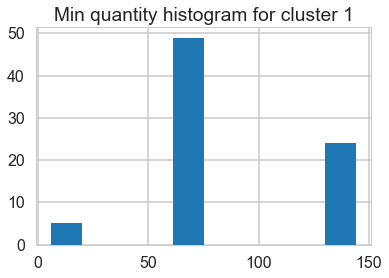

In [577]:
tmp = dft.loc[dfg.groups[1],:]
plt.hist(tmp.min_qty)
plt.title('Min quantity histogram for cluster 1')
print('Min quantity options:',tmp.min_qty.unique())

Discount values: [57 88 48 85 56 89 82 45 64 19 59 86 83 66 87 44 39 63 54]


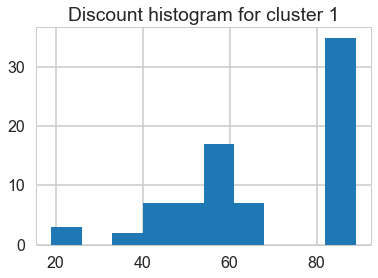

In [576]:
plt.hist(tmp.discount)
plt.title('Discount histogram for cluster 1')
print('Discount values:',tmp.discount.unique())

The high mean values of min quantity and discount on cluster 1 made us plot the histogram and examine further. It is interesting that customers of cluster 1 indeed like to buy in huge quantities, when more than 50% discount is available.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

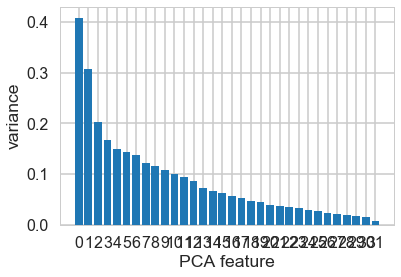

In [394]:
#your turn
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

From the barplot above, the difference between variance of feature index 4 and 5 is smaller than the differences before those. The elbow point can be taken at index 4. First 5 features are the most important PCA components. **Hence, possible value for the optimal number of dimensions is 5**

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


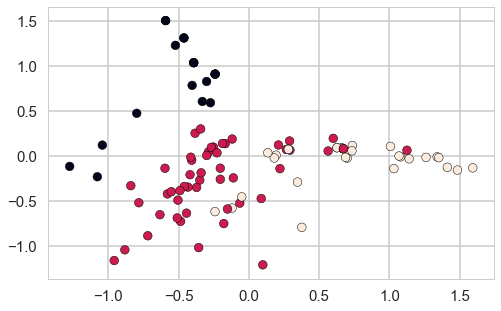

Estimated number of clusters: 3
Silhouette Coefficient: 0.067


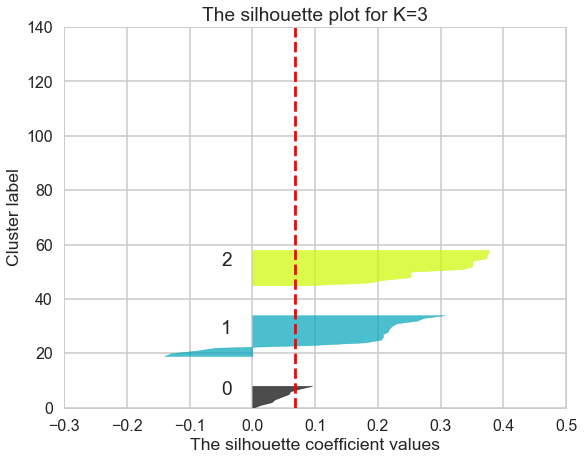

In [395]:
# Your turn
# 1. Affinity propagation
from sklearn.cluster import AffinityPropagation
from itertools import cycle
model = AffinityPropagation(preference=-30,damping=0.5).fit(X)
cluster_centers_indices = model.cluster_centers_
n_clusters = cluster_centers_indices.shape[0]
labels_af = model.labels_
plt.figure(figsize=(8,5))
plt.scatter(xx[:,0],xx[:,1],edgecolors='k',c=model.labels_,s=75)
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
sil_avg = silhoute_plot(X,model,n_clusters=n_clusters)
print('Estimated number of clusters: %d' % n_clusters)
print("Silhouette Coefficient: %0.3f"%sil_avg)

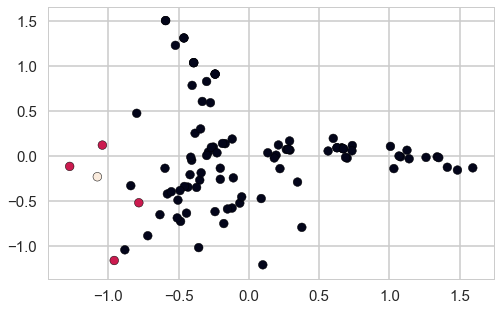

Estimated number of clusters: 3
Silhouette Coefficient: 0.078


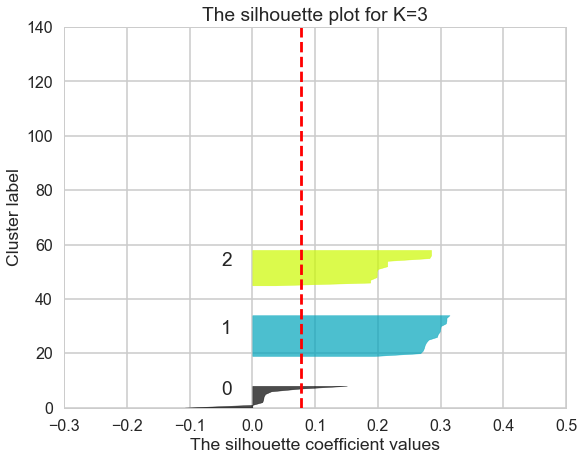

In [397]:
#3. Agglomerative clustering
import time
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
knn_graph = kneighbors_graph(X, 20, include_self=False)
n_cl_agg = 3
model = AgglomerativeClustering(linkage=linkage,connectivity=knn_graph,n_clusters=n_cl_agg)
model.fit(X)
plt.figure(figsize=(8,5))
plt.scatter(xx[:,0],xx[:,1],edgecolors='k',c=model.labels_,s=75)
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
sil_avg = silhoute_plot(X,model,n_clusters=n_cl_agg)
print('Estimated number of clusters: %d' % n_clusters)
print("Silhouette Coefficient: %0.3f"%sil_avg)

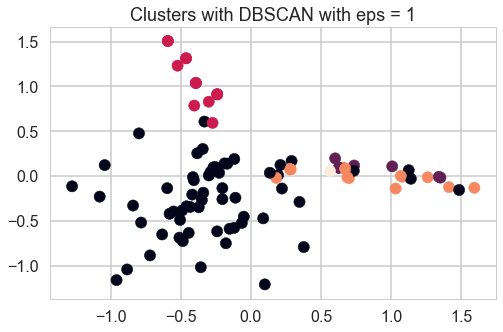

Estimated number of clusters: 3
Silhouette Coefficient: 0.015


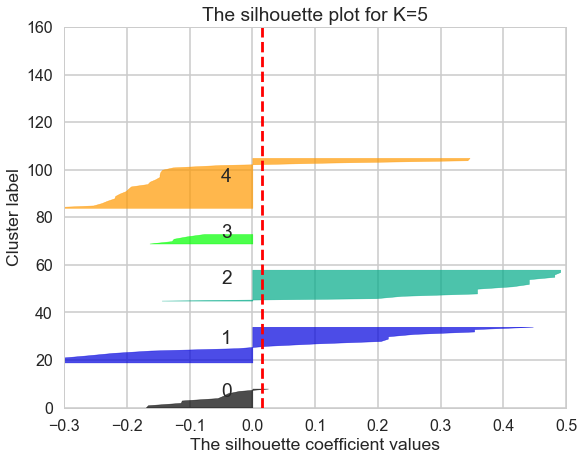

In [398]:
# 4. DBSCAN
from sklearn.cluster import DBSCAN
dbs = DBSCAN(eps=1)
dbs.fit(X)
plt.figure(figsize=(8,5))
plt.title("Clusters with DBSCAN with eps = 1", fontsize=18)
plt.grid(True)
plt.scatter(xx[:,0],xx[:,1],c=dbs.labels_)
plt.show()
sil_avg = silhoute_plot(X,dbs,n_clusters=5)
print('Estimated number of clusters: %d' % n_clusters)
print("Silhouette Coefficient: %0.3f"%sil_avg)

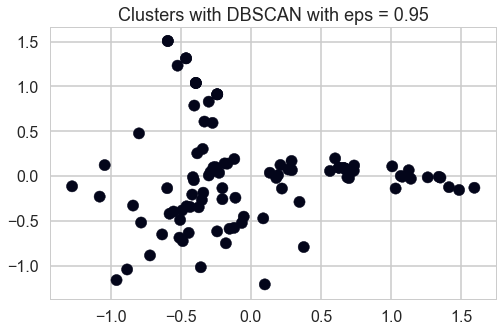

In [399]:
dbs = DBSCAN(eps=0.95)
dbs.fit(X)
plt.figure(figsize=(8,5))
plt.title("Clusters with DBSCAN with eps = 0.95", fontsize=18)
plt.grid(True)
plt.scatter(xx[:,0],xx[:,1],c=dbs.labels_)
plt.show()